# Plotting Hubway stations


The tutorial at http://introtopython.org/visualization_earthquakes.html has been a helpful a reference here.

In [28]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (8,6)

import urllib
from lxml import etree
import datetime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
import os
os.getcwd()

'C:\\Users\\Adam\\Dropbox\\datascience\\hubway'

In [30]:
data = etree.parse(urllib.urlopen('http://www.thehubway.com/data/stations/bikeStations.xml'))

In [31]:
lat = [float(elt.text) for elt in data.getiterator('lat')]
lon = [float(elt.text) for elt in data.getiterator('long')]
coords = zip(lat, lon)

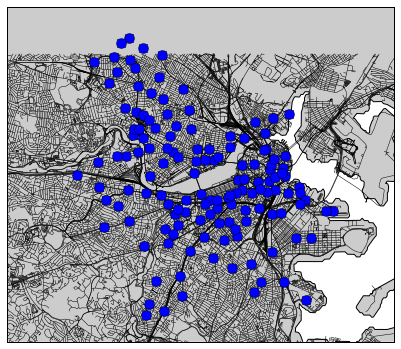

In [32]:
hub_map = Basemap(projection='merc', lat_0 = 42.34, lon_0 = -71.10,
    resolution = 'f', area_thresh = 0.1,
    llcrnrlon=-71.18, llcrnrlat=42.30,
    urcrnrlon=-71.00, urcrnrlat=42.415)
hub_map.readshapefile('../../../Documents/boston_massachusetts_osm_roads','roads')
hub_map.drawcoastlines()
hub_map.fillcontinents()
hub_map.drawmapboundary()
x,y = hub_map(lon, lat)
hub_map.plot(x, y, 'bo', markersize=10)

Able to plot each station! Unfortunately "Boston metro" shapefile served by Mapzen cuts off before the northernmost stations... have submitted an issue on github to try to fix.

Idea for next step: color by station code prefix ('A', 'B', ...). Will require a little more finesse in querying XML tree than just finding the 'lat' and 'long' and extracting the content from each of those.

## Import all data as a DataFrame

In [33]:
stations = data.findall('station')
everything = [[elt.text for elt in station.getchildren()] for station in stations]
df = pd.DataFrame(everything, columns = [elt.tag for elt in data.find('station')]).convert_objects(convert_numeric=True)
df.set_index('name', inplace=True)

In [34]:
df.head()

,id,terminalName,lastCommWithServer,lat,long,installed,locked,installDate,removalDate,temporary,public,nbBikes,nbEmptyDocks,latestUpdateTime
name,,,,,,,,,,,,,,
Colleges of the Fenway,3,B32006,1443184843625,42.340021,-71.100812,true,false,0,None,false,true,4,11,1443184484759
Tremont St. at Berkeley St.,4,C32000,1443184809159,42.345392,-71.069616,true,false,0,None,false,true,4,11,1443184567510
Northeastern U / North Parking Lot,5,B32012,1443184852568,42.341814,-71.090179,true,false,0,None,false,true,3,11,1443183209137
Cambridge St. at Joy St.,6,D32000,1443184824213,42.361174,-71.065142,true,false,0,None,false,true,2,12,1443184584919
Fan Pier,7,A32000,1443184878307,42.353287,-71.044389,true,false,0,None,false,true,7,7,1443184372189


## Make map colored by terminalName letter code

In [35]:
for name, group in df.groupby(lambda x: df.terminalName[x][0]):
    print name

A
B
C
D
E
K
M
S


In [36]:
# rather than some kind of looping through groupby madness, just hardcode a color for each scraped letter code
colordict = {'A':'blue','B':'green','C':'yellow','D':'red','E':'orange','K':'purple','M':'pink','S':'white'}

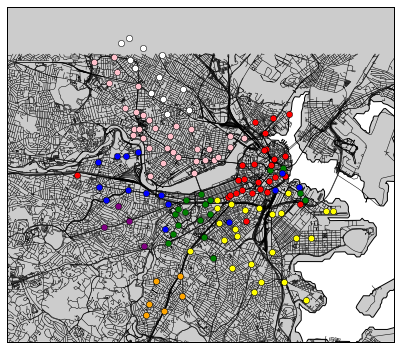

In [37]:
hub_map_color = Basemap(projection='merc', lat_0 = 42.34, lon_0 = -71.10,
    resolution = 'f', area_thresh = 0.1,
    llcrnrlon=-71.18, llcrnrlat=42.30,
    urcrnrlon=-71.00, urcrnrlat=42.415)
hub_map_color.readshapefile('../../../Documents/boston_massachusetts_osm_roads','roads')
hub_map_color.drawcoastlines()
hub_map_color.fillcontinents()
hub_map_color.drawmapboundary()
for station in df.index:
    x,y = hub_map_color(float(df.long[station]), float(df.lat[station]))
    hub_map_color.plot(x, y, marker='o', color = colordict[df.terminalName[station][0]])

It does look basically geographical! Except I don't understand the few strange outliers...

## Plot station spot size by capacity

Assume that total capacity is sum of number of bikes and number of empty docks. Could vary somewhat with time if the system knows of any docks out of commission.

In [38]:
df['capacity'] = df['nbBikes'] + df['nbEmptyDocks']

In [39]:
df.head()

,id,terminalName,lastCommWithServer,lat,long,installed,locked,installDate,removalDate,temporary,public,nbBikes,nbEmptyDocks,latestUpdateTime,capacity
name,,,,,,,,,,,,,,,
Colleges of the Fenway,3,B32006,1443184843625,42.340021,-71.100812,true,false,0,None,false,true,4,11,1443184484759,15
Tremont St. at Berkeley St.,4,C32000,1443184809159,42.345392,-71.069616,true,false,0,None,false,true,4,11,1443184567510,15
Northeastern U / North Parking Lot,5,B32012,1443184852568,42.341814,-71.090179,true,false,0,None,false,true,3,11,1443183209137,14
Cambridge St. at Joy St.,6,D32000,1443184824213,42.361174,-71.065142,true,false,0,None,false,true,2,12,1443184584919,14
Fan Pier,7,A32000,1443184878307,42.353287,-71.044389,true,false,0,None,false,true,7,7,1443184372189,14


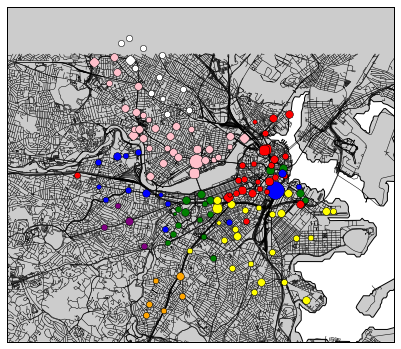

In [41]:
hub_map_color = Basemap(projection='merc', lat_0 = 42.34, lon_0 = -71.10,
    resolution = 'f', area_thresh = 0.1,
    llcrnrlon=-71.18, llcrnrlat=42.30,
    urcrnrlon=-71.00, urcrnrlat=42.415)
hub_map_color.readshapefile('../../../Documents/boston_massachusetts_osm_roads','roads')
hub_map_color.drawcoastlines()
hub_map_color.fillcontinents()
hub_map_color.drawmapboundary()
for station in df.index:
    x,y = hub_map_color(float(df.long[station]), float(df.lat[station]))
    hub_map_color.plot(x, y, marker='o',
                       color = colordict[df.terminalName[station][0]],
                      markersize = df.capacity[station] * 0.4)

Also make histogram showing size distribution. Bin by integer.

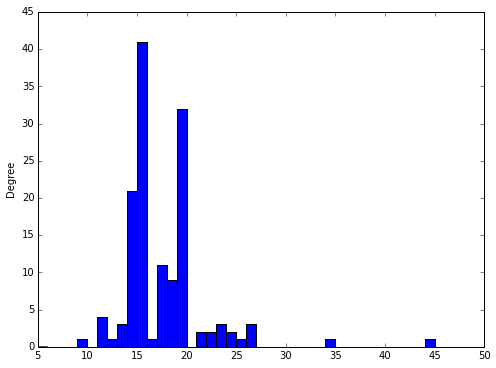

In [54]:
df['capacity'].plot(kind='hist', bins=45, range=(5,50))

Possibly the stations with capacity N-1 and N-2 relative to big peaks at 16 and 19 have docks out of service?